# Notes

TODO

In [1]:
import os 
import re
import csv
import json
import math
from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# Constants

In [2]:
SEQ_MAX_LEN = 600
NUM_CLASSES = 6
NUM_EXERCISES = 9
NUM_FLAG_BS = 2

In [3]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'exercises_raw_heathy')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'exercises_test')

# Data prep

In [4]:
from utils.input import setup, exercise_to_input

In [5]:
setup(os.path.join('..'), SEQ_MAX_LEN, NUM_EXERCISES, NUM_FLAG_BS)

{'ROOT_PATH': '..',
 'ALL_REGIONS': ['frontal', 'orbital', 'oral'],
 'REGIONS': {'0_LefteyeMidbottom': 'orbital',
  '1_LefteyeMidtop': 'orbital',
  '2_LefteyeInnercorner': 'orbital',
  '3_LefteyeOutercorner': 'orbital',
  '4_LefteyebrowInner': 'frontal',
  '5_LefteyebrowCenter': 'frontal',
  '6_RighteyeMidbottom': 'orbital',
  '7_RighteyeMidtop': 'orbital',
  '8_RighteyeInnercorner': 'orbital',
  '9_RighteyeOutercorner': 'orbital',
  '10_RighteyebrowInner': 'frontal',
  '11_RighteyebrowCenter': 'frontal',
  '12_NoseTip': 'frontal',
  '13_MouthLowerlipMidbottom': 'oral',
  '14_MouthLeftcorner': 'oral',
  '15_MouthRightcorner': 'oral',
  '16_MouthUpperlipMidtop': 'oral',
  '17_ChinCenter': 'oral',
  '18_ForeheadCenter': 'frontal',
  '19_LeftcheekCenter': 'oral',
  '20_RightcheekCenter': 'oral'},
 'BASES': {'0_LefteyeMidbottom': '18_ForeheadCenter',
  '1_LefteyeMidtop': '18_ForeheadCenter',
  '2_LefteyeInnercorner': '18_ForeheadCenter',
  '3_LefteyeOutercorner': '18_ForeheadCenter',
  '4_

In [6]:
exercises_sources = [
    #dir_exercises_test
    dir_exercises,
]

In [7]:
feature_engineering_setting = {
    'coordinates': True,
    're_base': True,
    'normalize_by_start': False,
    'normalize': False,
    'direction': True,
    'distance': True,
}

In [8]:
xslist_meta = list()
xslist_global = list()
xslist_frontal = list()
xslist_oral = list()
xslist_orbital = list()
yslist = list()


for exercise_source in exercises_sources:
    for file_name in os.listdir(exercise_source):
        file_path = os.path.join(exercise_source, file_name)

        if file_name == '.DS_Store': continue

        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_path, feature_engineering_setting)

        yslist.append(_ys)
        xslist_meta.append(_xs_meta)  
        xslist_global.append(_xs_global)
        xslist_frontal.append(_xs_frontal)
        xslist_oral.append(_xs_oral)
        xslist_orbital.append(_xs_orbital)
            
ys = np.array(yslist, dtype='float32')
xs_meta = np.array(xslist_meta, dtype='float32')   
xs_global = np.array(xslist_global, dtype='float32') 
xs_frontal = np.array(xslist_frontal, dtype='float32') 
xs_oral = np.array(xslist_oral, dtype='float32') 
xs_orbital = np.array(xslist_orbital, dtype='float32') 

print(ys.shape)
print(xs_meta.shape)
print(xs_global.shape)
print(xs_frontal.shape)
print(xs_oral.shape)
print(xs_orbital.shape)

(719,)
(719, 11)
(719, 210, 600)
(719, 60, 600)
(719, 70, 600)
(719, 80, 600)


# Inference

## Load Model

In [9]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type4-with-fe')
#type4-with-fe
#type4-with-fe_reflect_score
#type4-with-fe-no_augmentation

## Infer

In [10]:
model = tf.keras.models.load_model(dir_model)

Metal device set to: Apple M1


2023-12-26 12:03:34.275010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-26 12:03:34.275283: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 210, 600)]   0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 60, 600)]    0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 70, 600)]    0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 80, 600)]    0           []                               
                                                                                           

 batch_normalization_18 (BatchN  (None, 52, 64)      256         ['conv1d_18[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_22 (BatchN  (None, 15, 64)      256         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_26 (BatchN  (None, 17, 64)      256         ['conv1d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_30 (BatchN  (None, 20, 64)      256         ['conv1d_30[0][0]']              
 ormalizat

                                                                                                  
 concatenate_1 (Concatenate)    (None, 516)          0           ['dense_7[0][0]',                
                                                                  'dense_8[0][0]',                
                                                                  'dense_9[0][0]',                
                                                                  'dense_10[0][0]',               
                                                                  'dense_11[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 32)           16544       ['concatenate_1[0][0]']          
                                                                                                  
 dense_13 (Dense)               (None, 6)            198         ['dense_12[0][0]']               
          

In [12]:
ys_pred = model.predict([
        xs_meta,
        xs_global,
        xs_frontal,
        xs_oral,
        xs_orbital],verbose=0)
ys_pred_bool = np.argmax(ys_pred, axis=1)

print(classification_report(ys, ys_pred_bool))

2023-12-26 12:03:39.708060: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-26 12:03:39.920061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       710
         2.0       1.00      1.00      1.00         9

    accuracy                           1.00       719
   macro avg       1.00      1.00      1.00       719
weighted avg       1.00      1.00      1.00       719



# Visualize patient exercises

In [13]:
from operator import attrgetter

In [14]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

In [15]:
exercises_number = 9

## Single patient with details

In [16]:
def plot_patient(patient_id):
    exercises_result = []

    fig, axs = plt.subplots(1,9,figsize=(15,2)) 


    for exercise_id in range(exercises_number):
        file_name = os.path.join(
            dir_exercises, 
            f'0000000{patient_id}_{patient_id}_{exercise_id}.json'
        )

        if not os.path.isfile(file_name):
            print(f'File {file_name} is missing')
            continue

        _xs_meta, _xs_global, _xs_frontal, _xs_oral, _xs_orbital, _ys = exercise_to_input(file_name, feature_engineering_setting)


        xs_meta = np.array([_xs_meta])   
        xs_global = np.array([_xs_global]) 
        xs_frontal = np.array([_xs_frontal]) 
        xs_oral = np.array([_xs_oral]) 
        xs_orbital = np.array([_xs_orbital])         
        
        ys_pred = model.predict([
            xs_meta,
            xs_global,
            xs_frontal,
            xs_oral,
            xs_orbital],verbose=0)
        exercises_result.append(list(ys_pred[0]))

        axs[exercise_id].bar(1 + np.arange(6), ys_pred[0], width=1, edgecolor="white", linewidth=0.7)

        axs[exercise_id].set(
            xlim=(0, 7), 
            xticks=np.arange(1, 7),
            ylim=(0, 1))


    plt.show()    

In [17]:
def all_patients():
    ids = set()
    for file in os.listdir(dir_exercises):
        id = file.split('_')[0][7:]
        ids.add(id)
        
    return sorted(ids)

2023-12-26 12:03:42.059710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


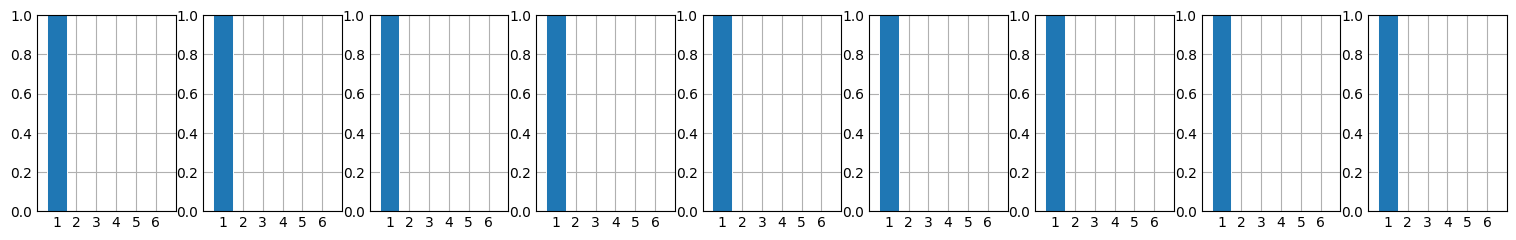

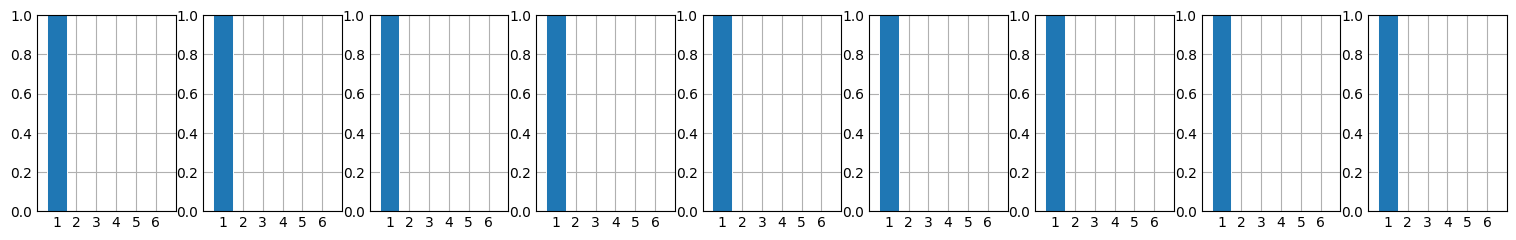

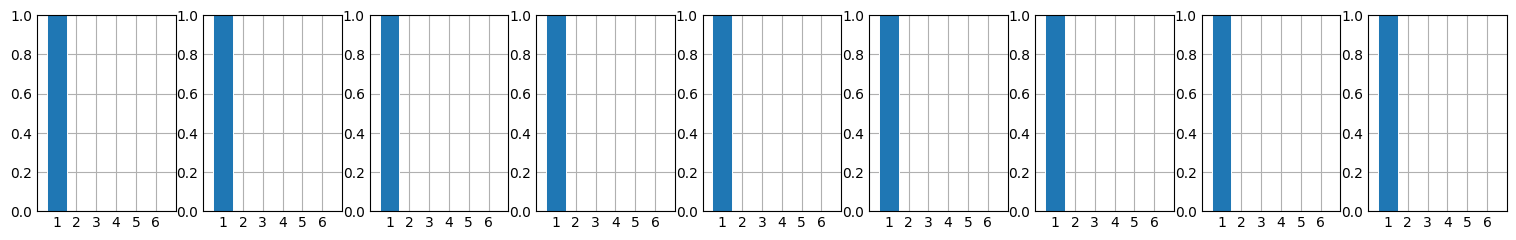

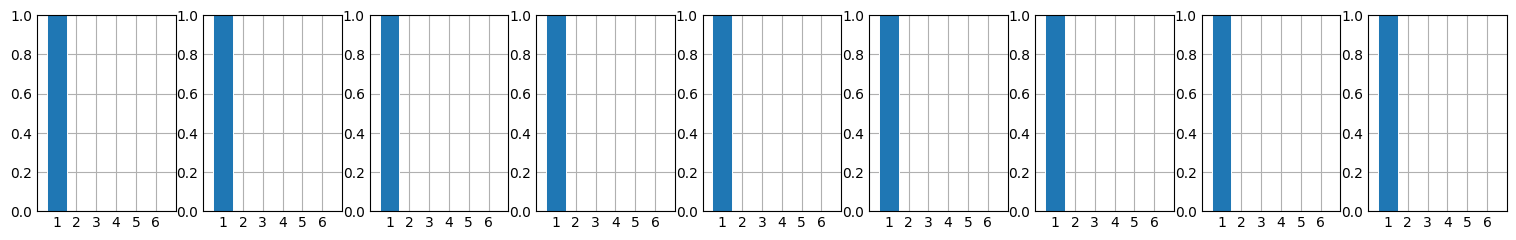

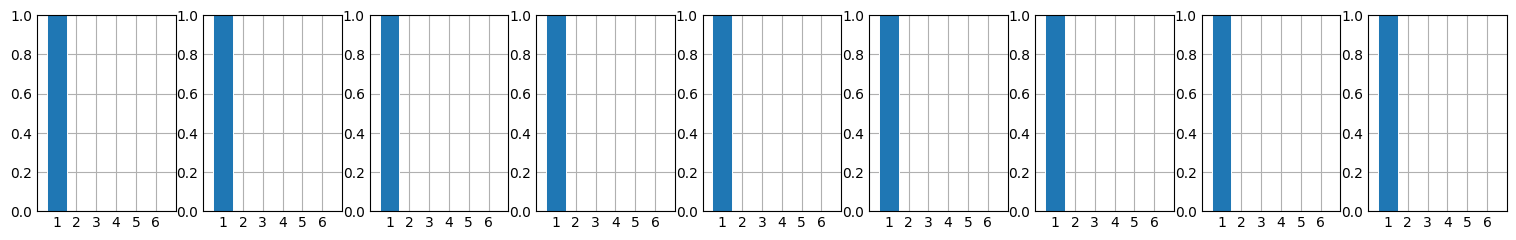

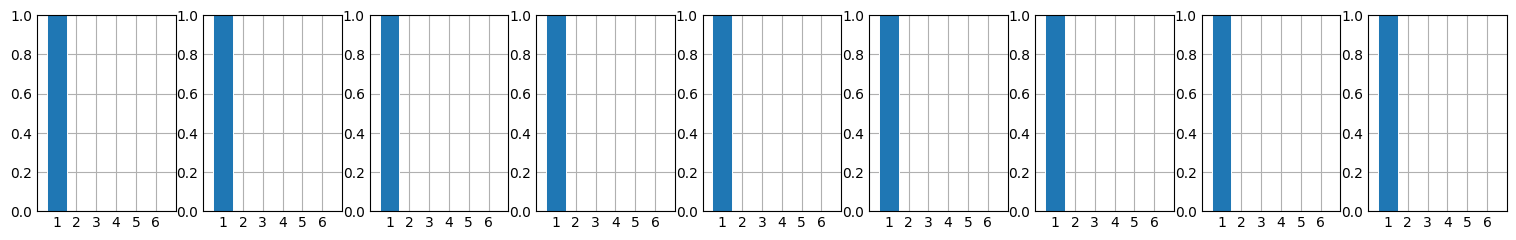

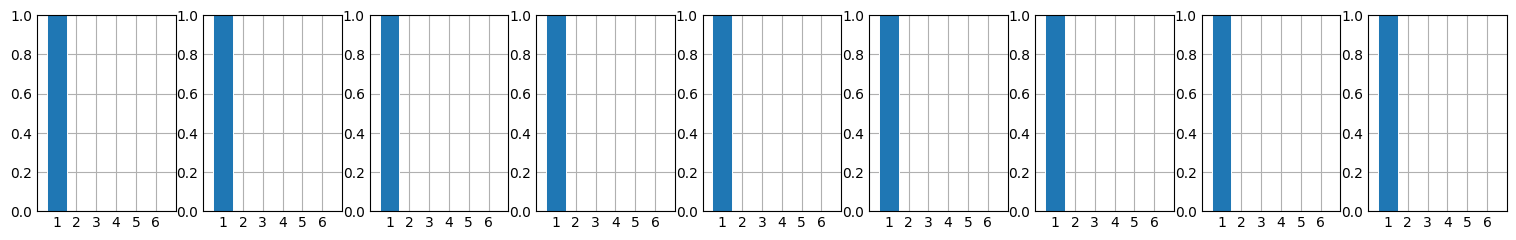

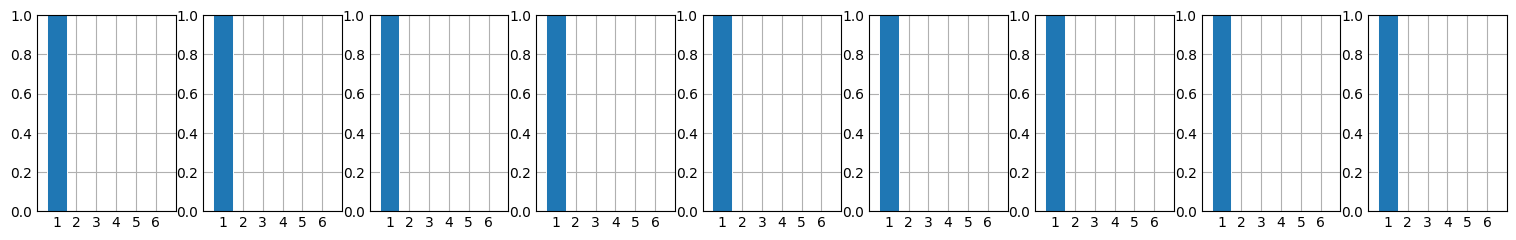

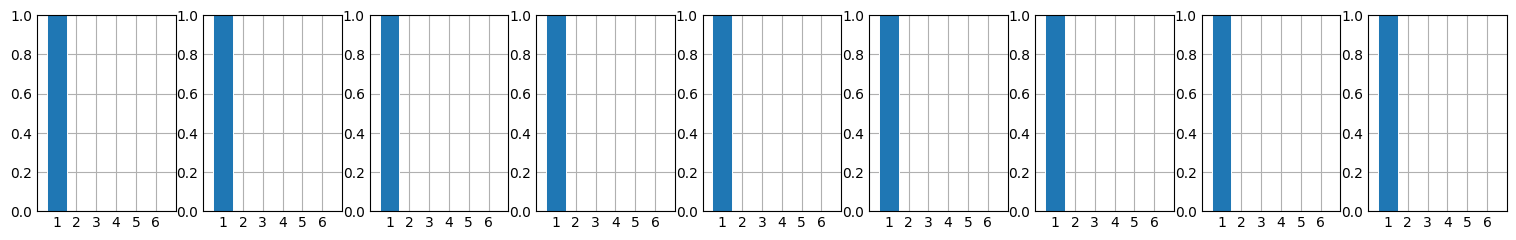

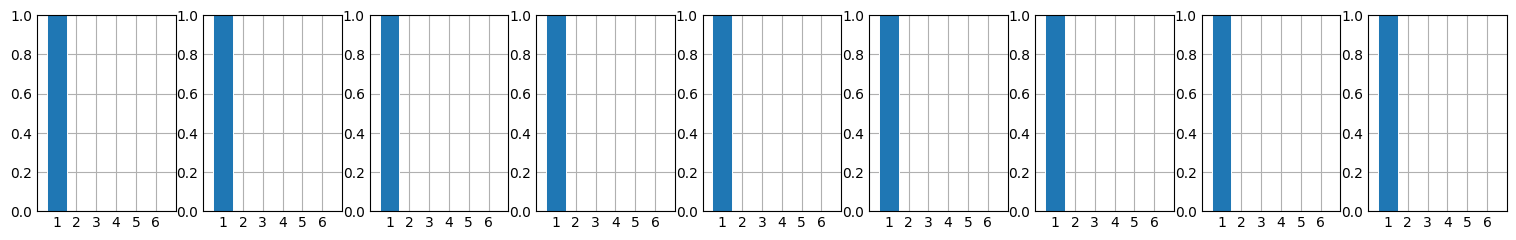

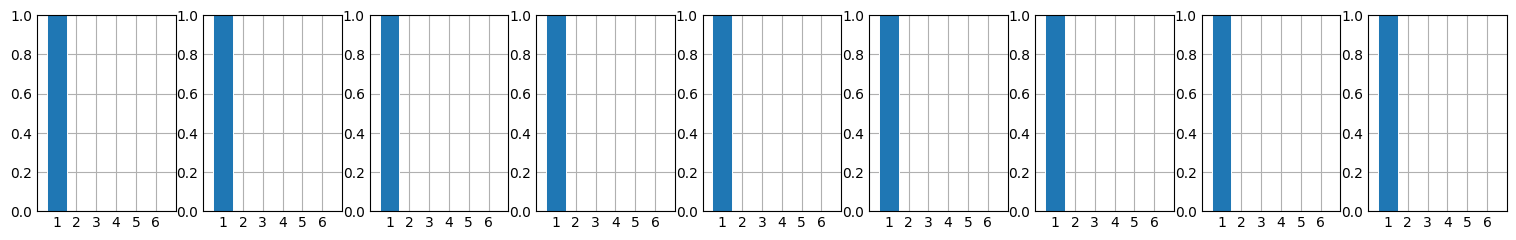

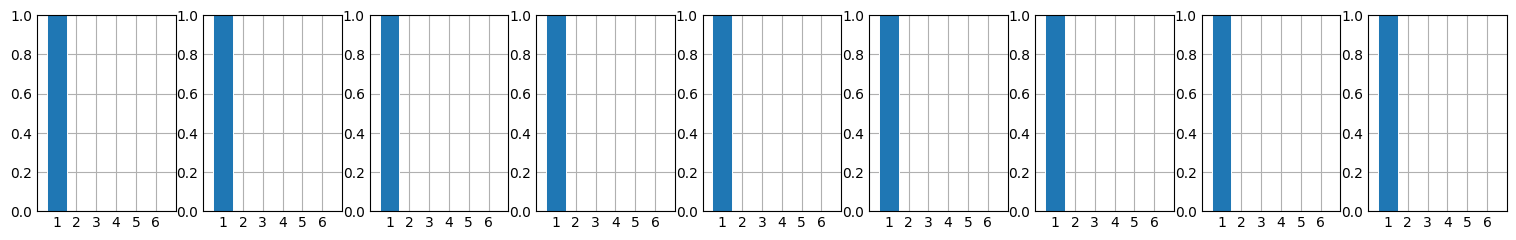

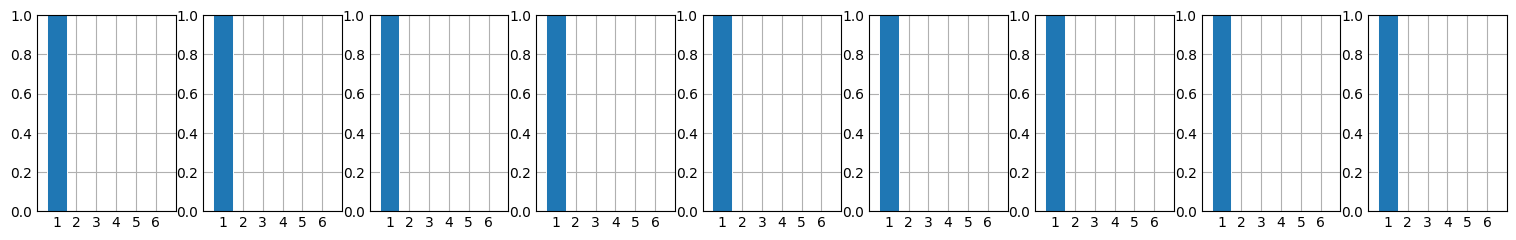

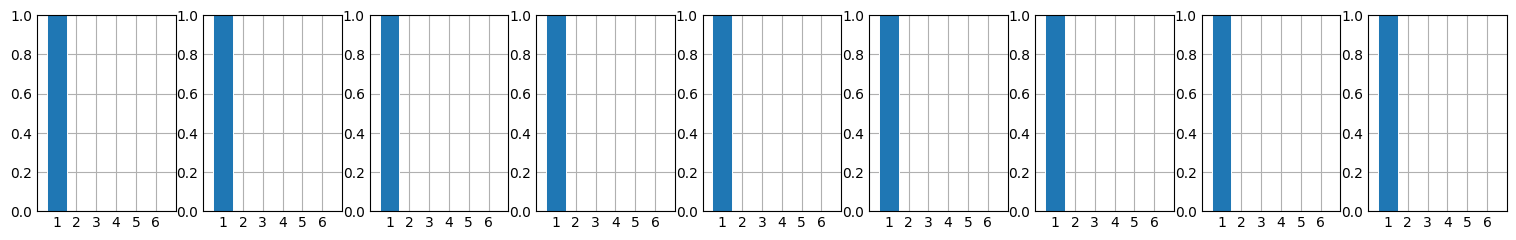

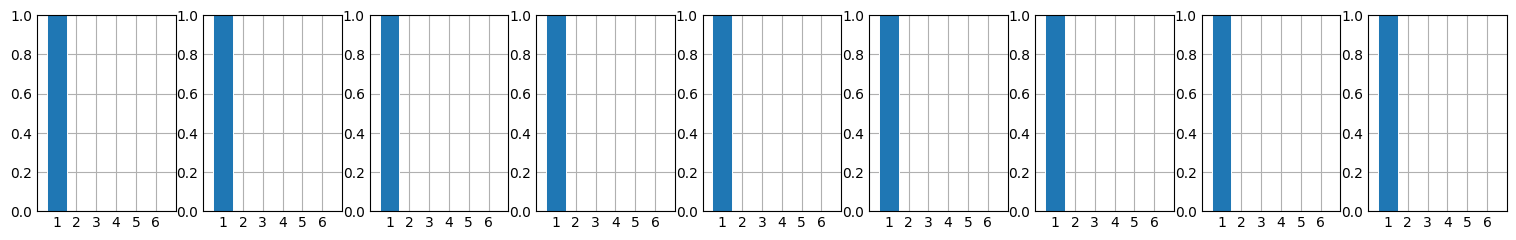

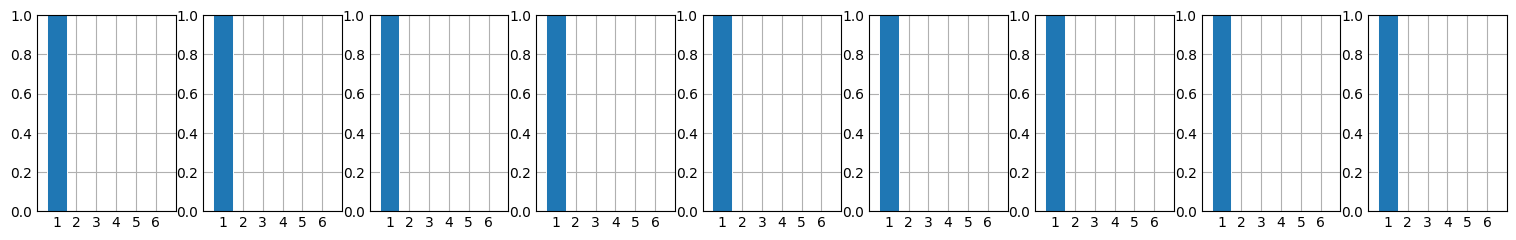

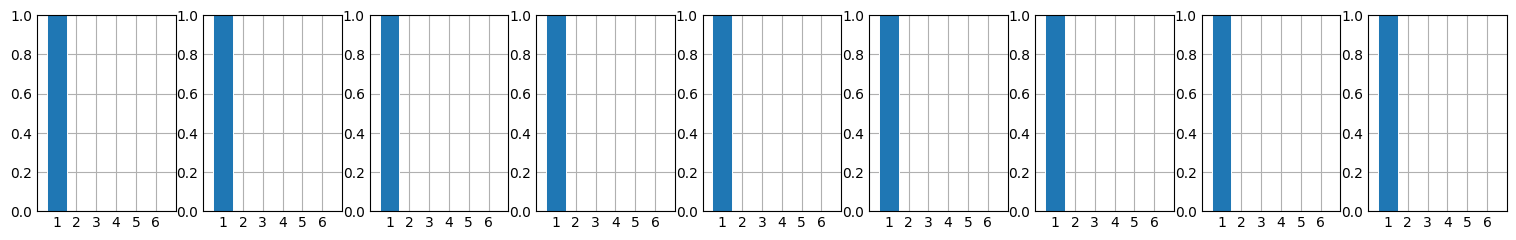

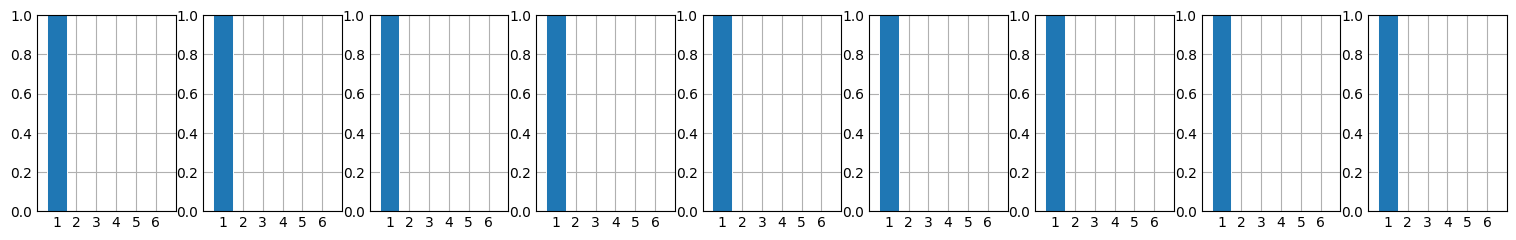

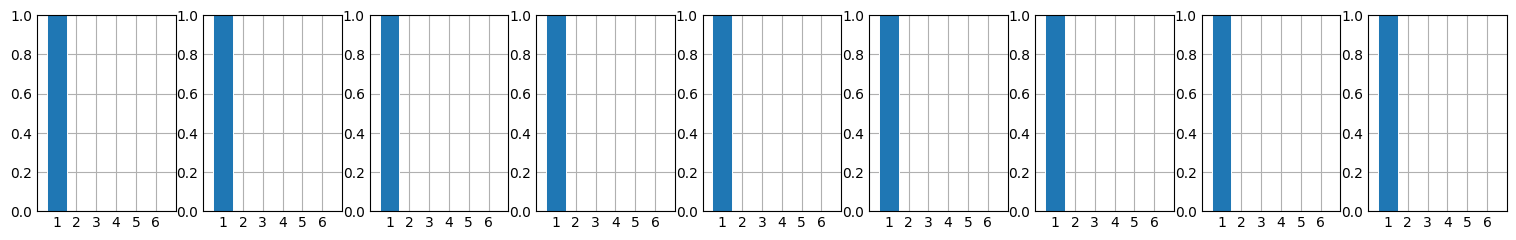

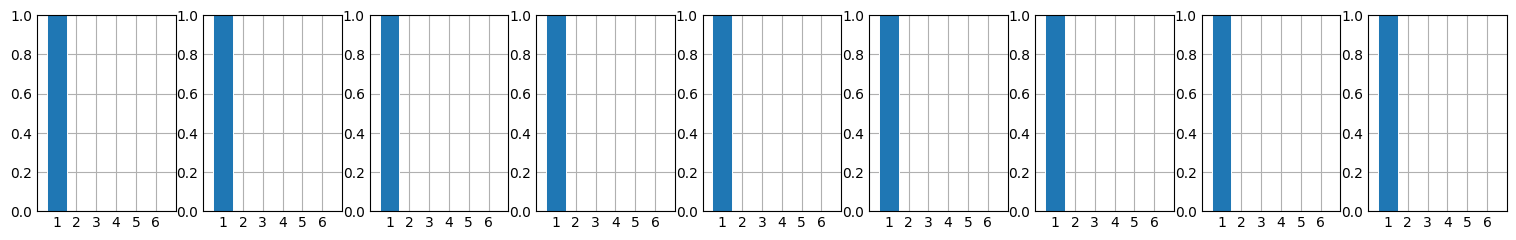

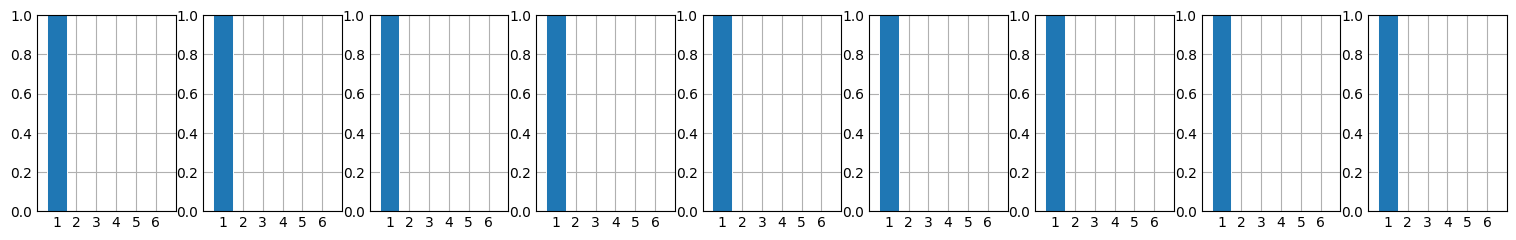

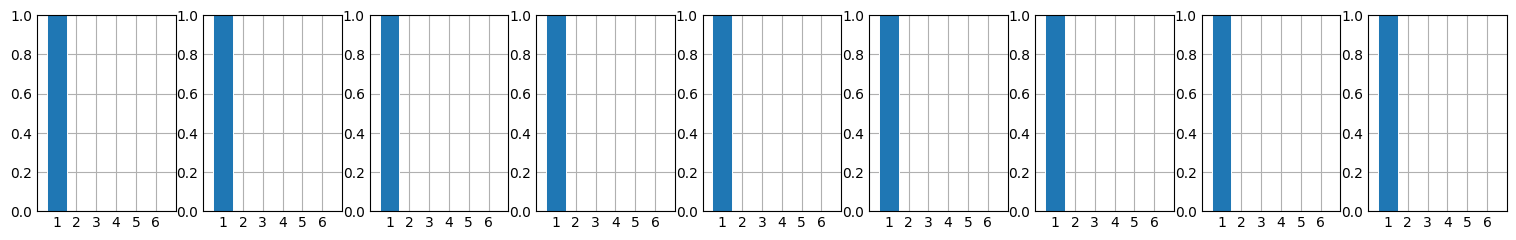

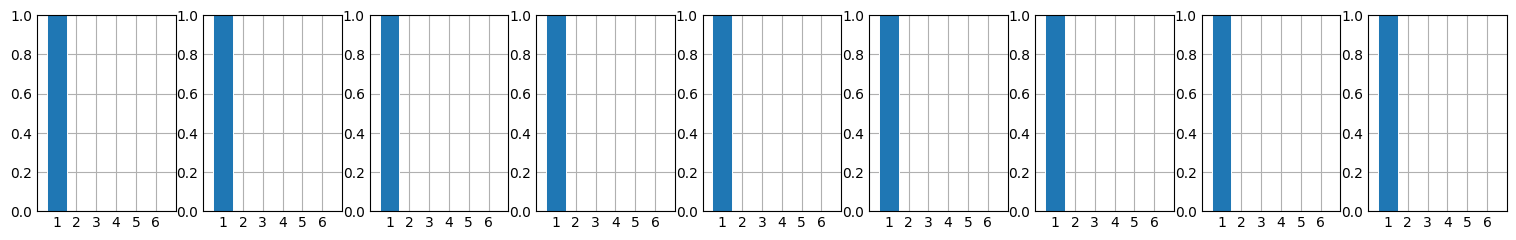

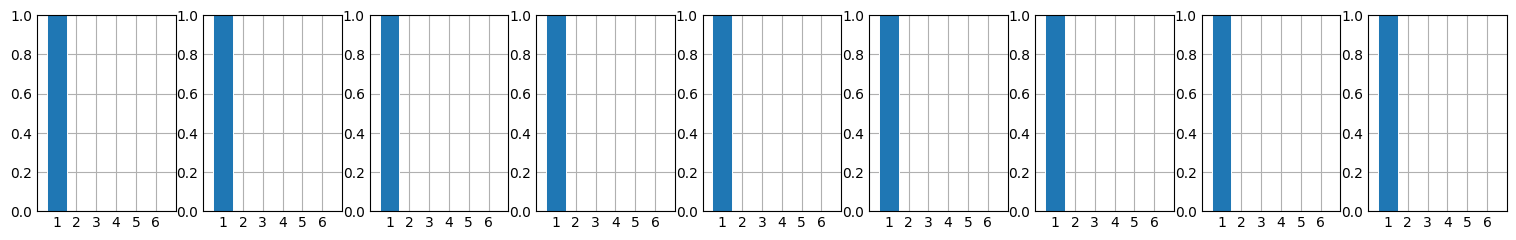

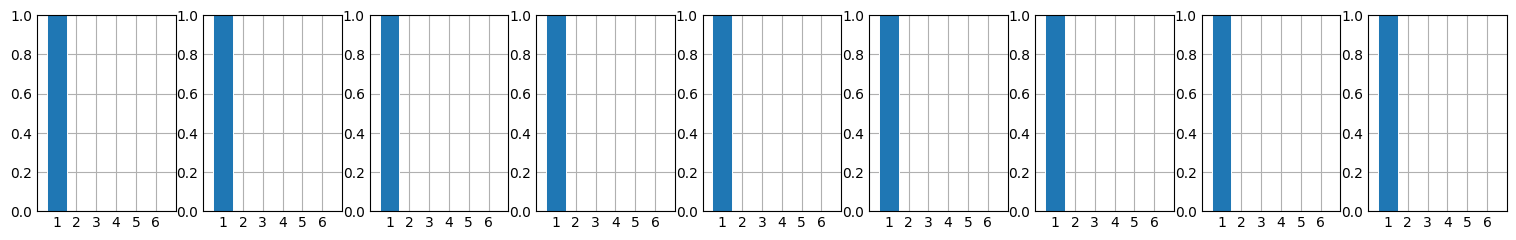

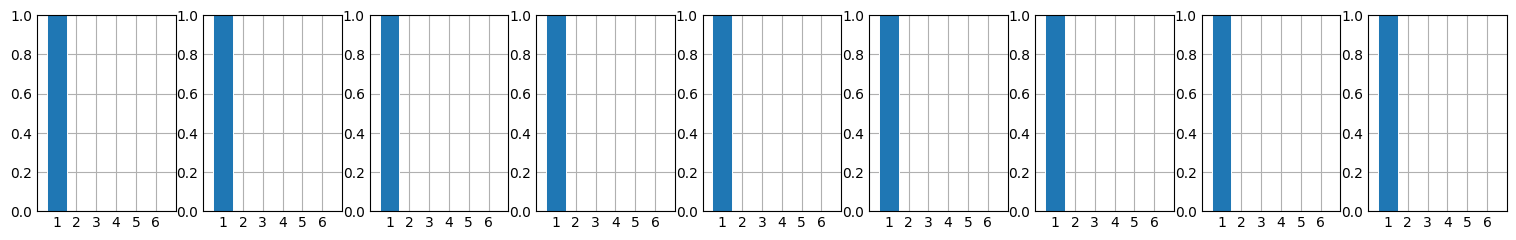

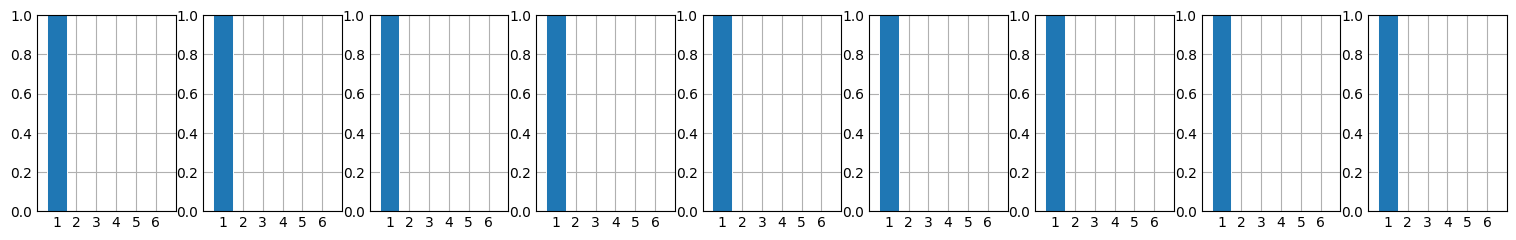

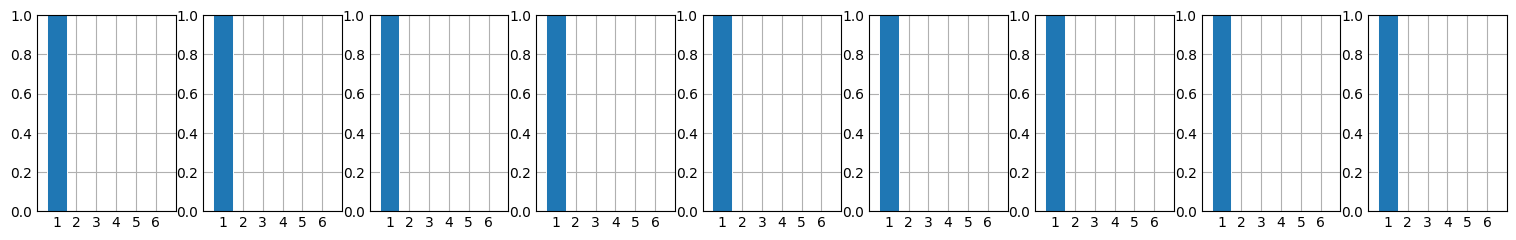

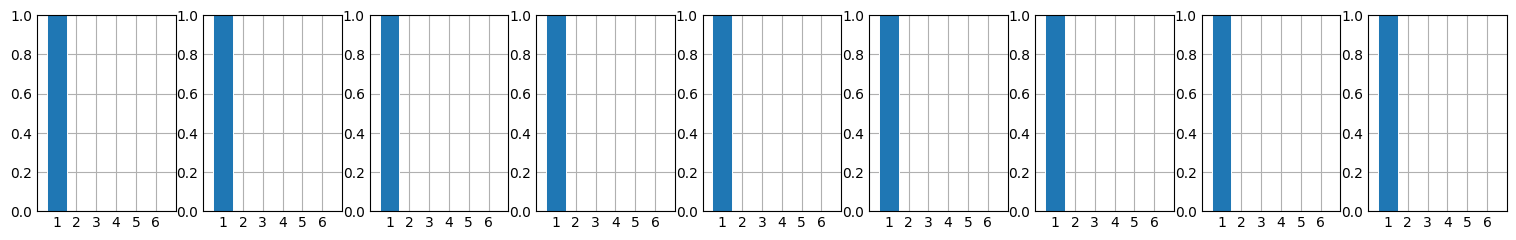

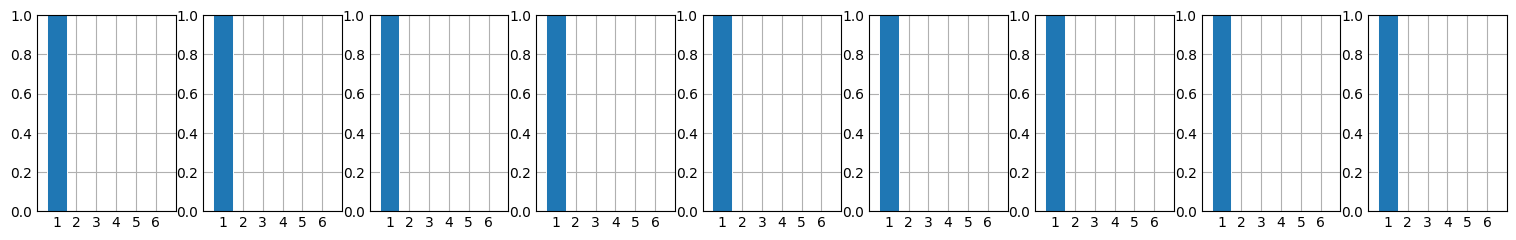

File ../data/json/exercises_raw_heathy/0000000259_259_0.json is missing
File ../data/json/exercises_raw_heathy/0000000259_259_1.json is missing
File ../data/json/exercises_raw_heathy/0000000259_259_2.json is missing
File ../data/json/exercises_raw_heathy/0000000259_259_3.json is missing
File ../data/json/exercises_raw_heathy/0000000259_259_4.json is missing
File ../data/json/exercises_raw_heathy/0000000259_259_5.json is missing
File ../data/json/exercises_raw_heathy/0000000259_259_6.json is missing
File ../data/json/exercises_raw_heathy/0000000259_259_7.json is missing


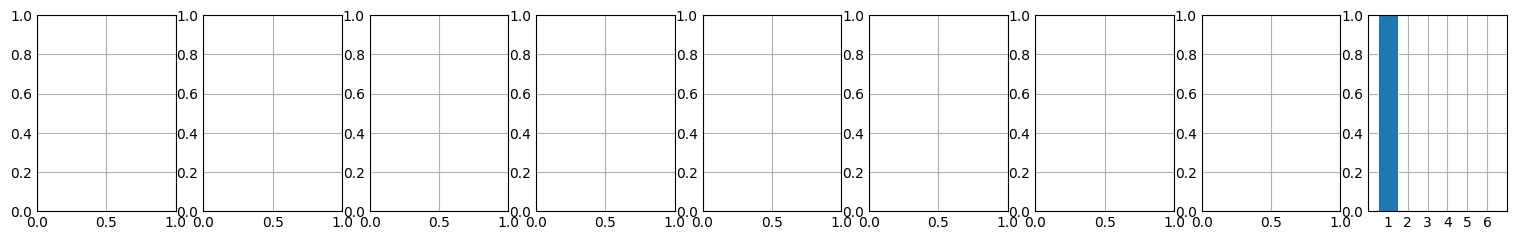

File ../data/json/exercises_raw_heathy/0000000262_262_0.json is missing
File ../data/json/exercises_raw_heathy/0000000262_262_1.json is missing
File ../data/json/exercises_raw_heathy/0000000262_262_2.json is missing


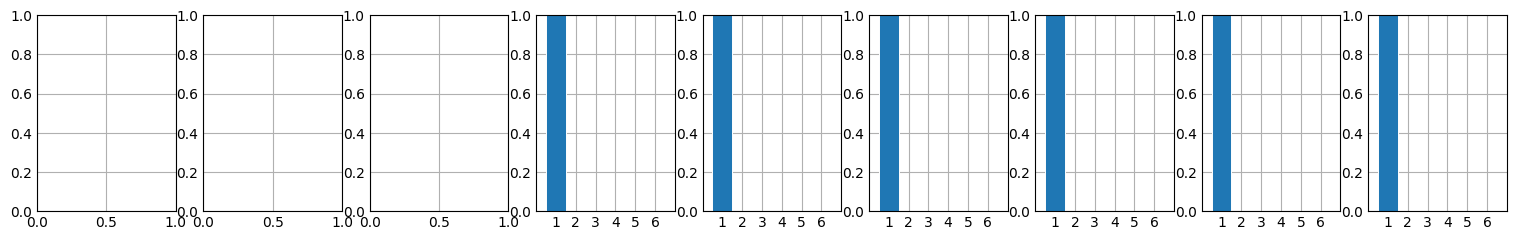

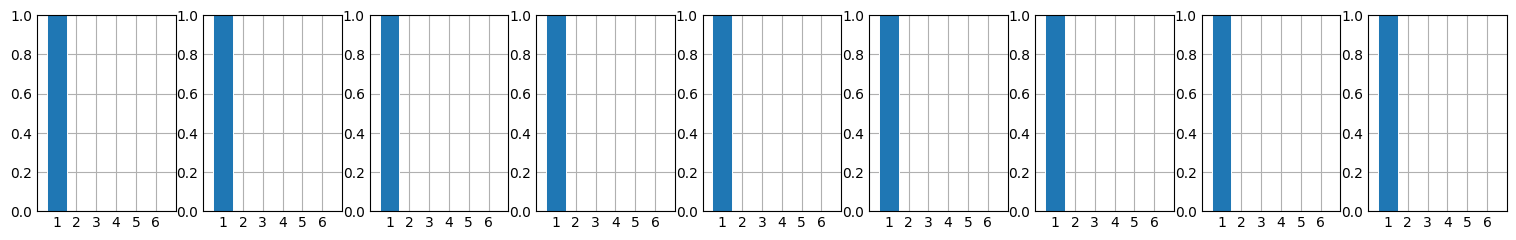

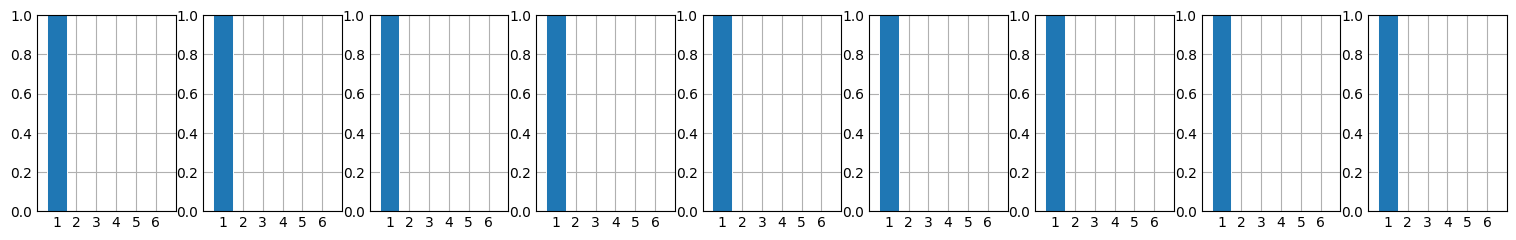

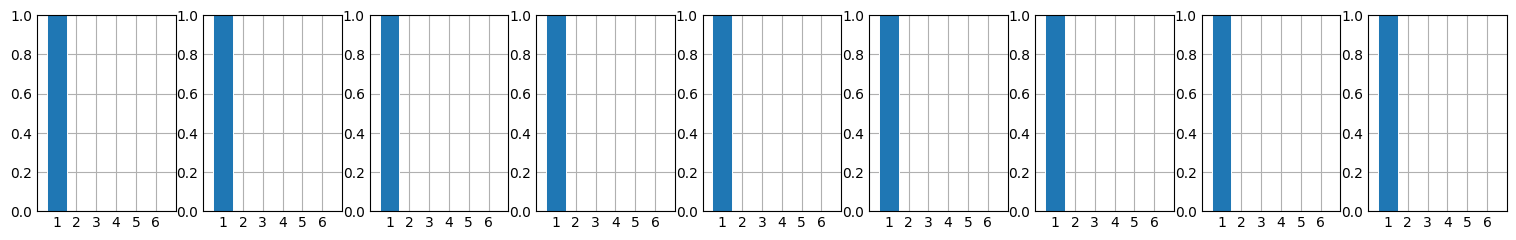

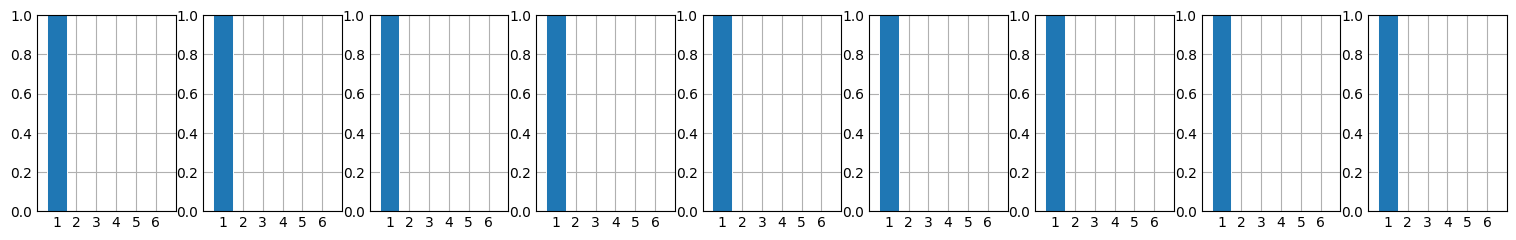

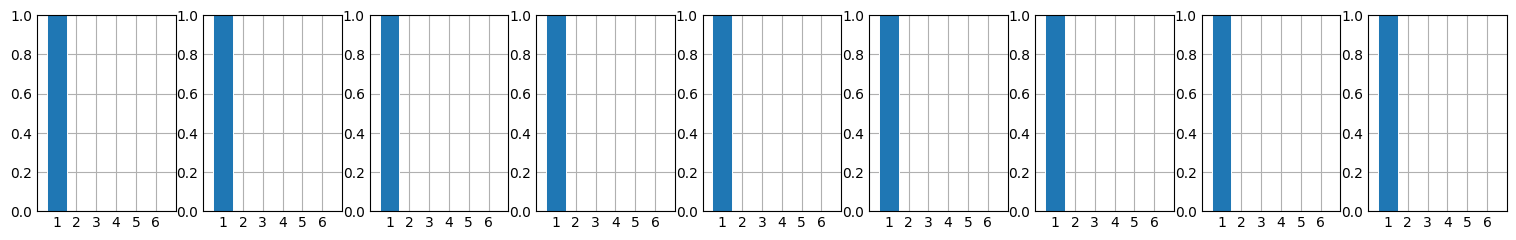

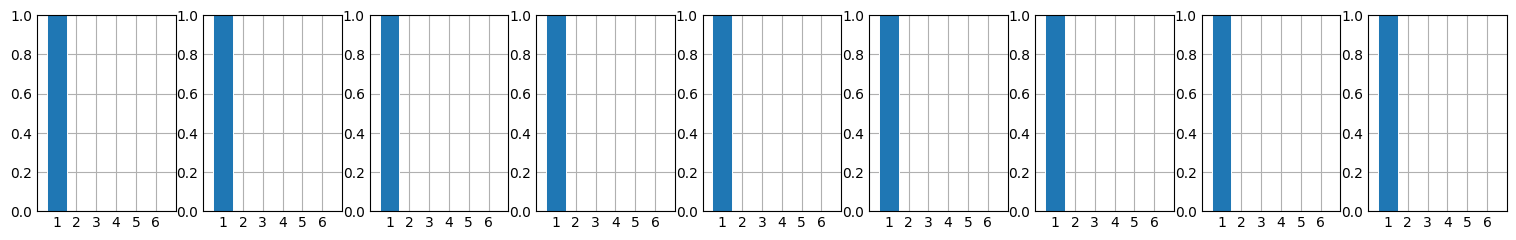

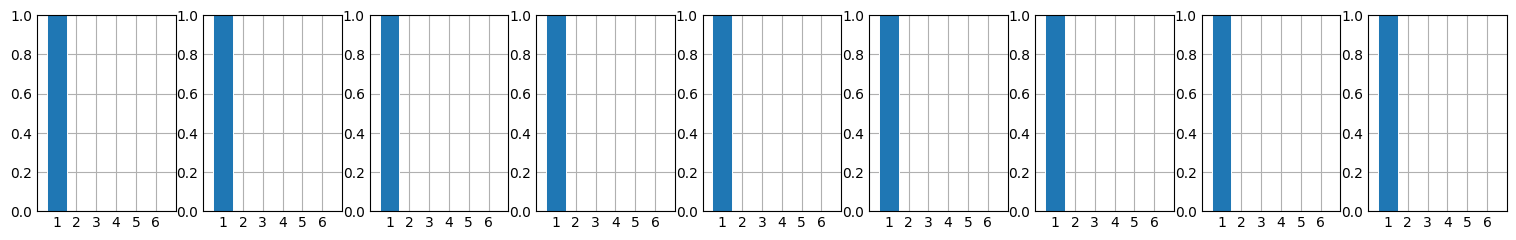

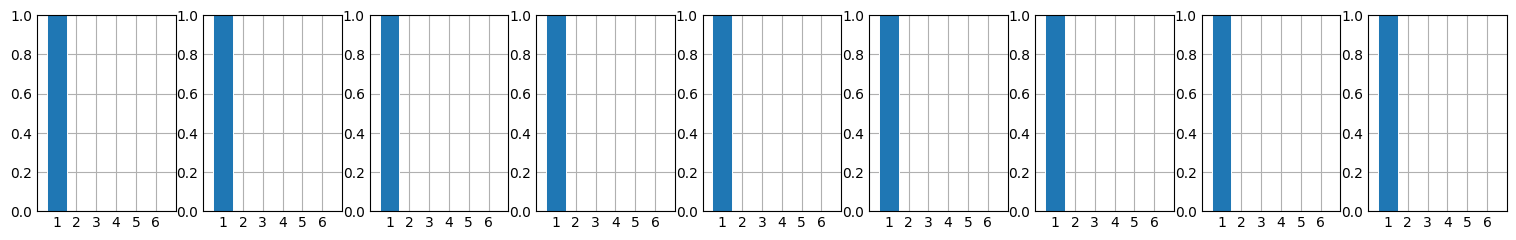

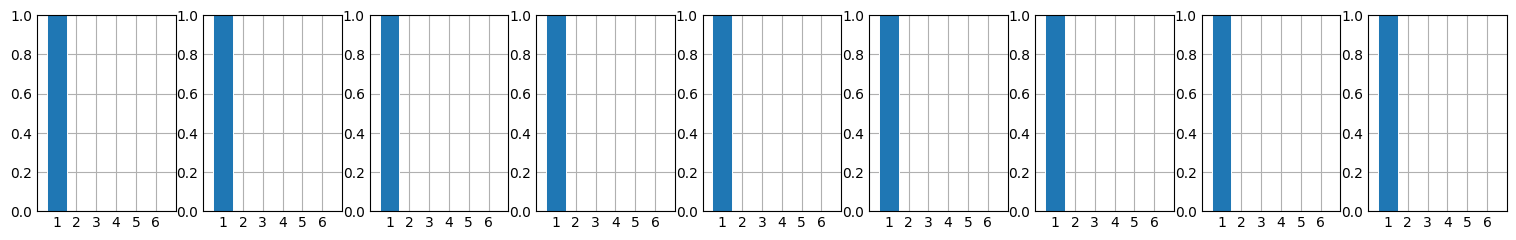

File ../data/json/exercises_raw_heathy/0000000295_295_0.json is missing
File ../data/json/exercises_raw_heathy/0000000295_295_1.json is missing
File ../data/json/exercises_raw_heathy/0000000295_295_2.json is missing
File ../data/json/exercises_raw_heathy/0000000295_295_3.json is missing
File ../data/json/exercises_raw_heathy/0000000295_295_4.json is missing
File ../data/json/exercises_raw_heathy/0000000295_295_6.json is missing
File ../data/json/exercises_raw_heathy/0000000295_295_7.json is missing
File ../data/json/exercises_raw_heathy/0000000295_295_8.json is missing


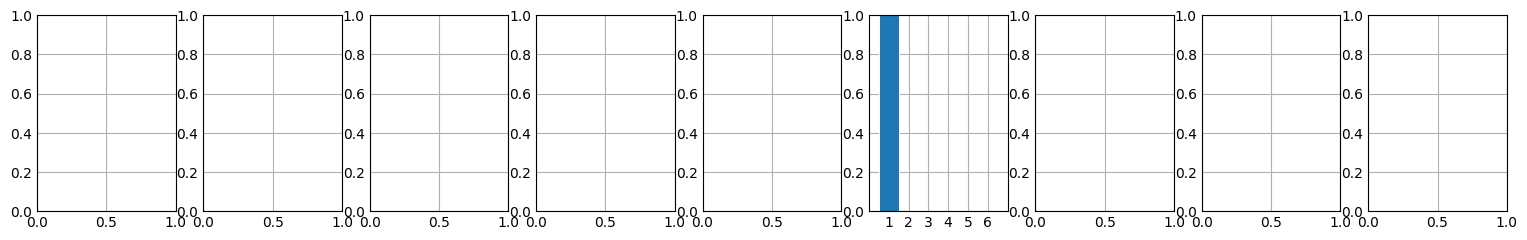

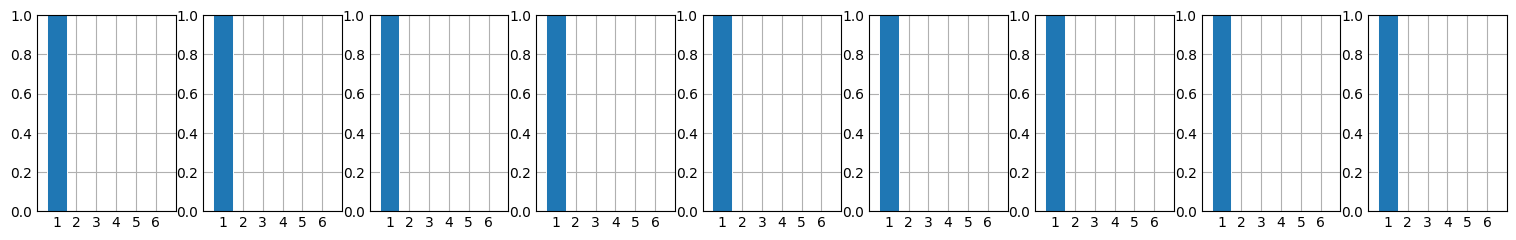

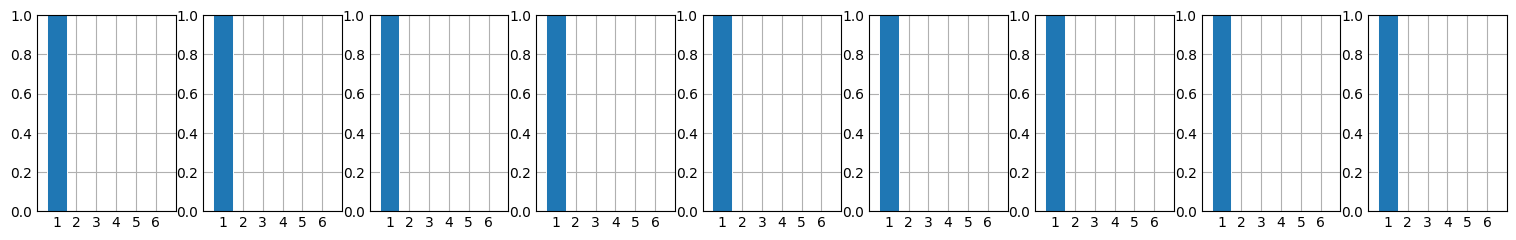

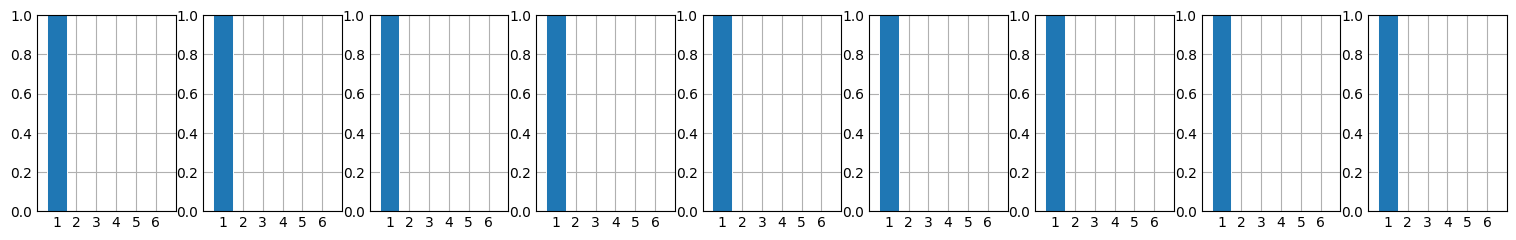

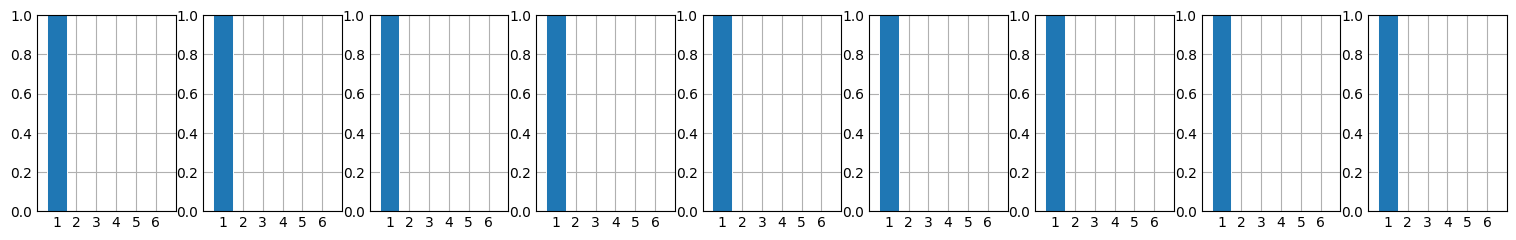

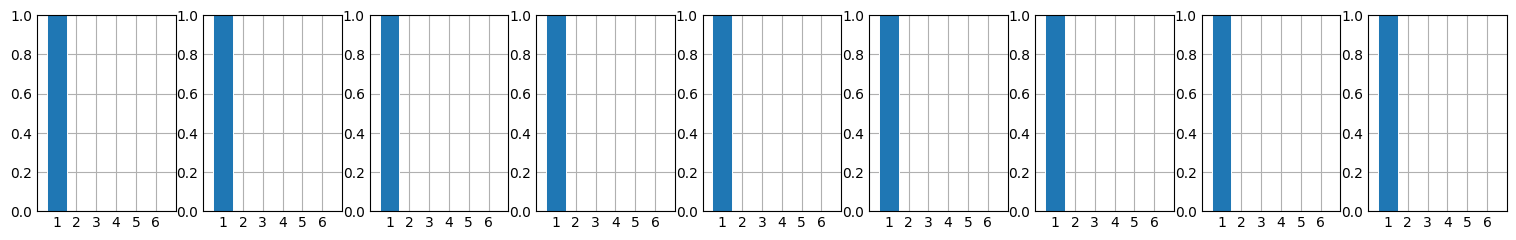

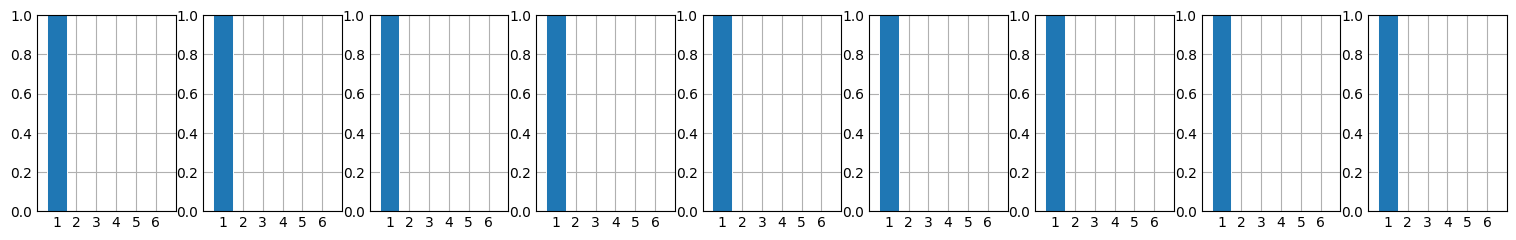

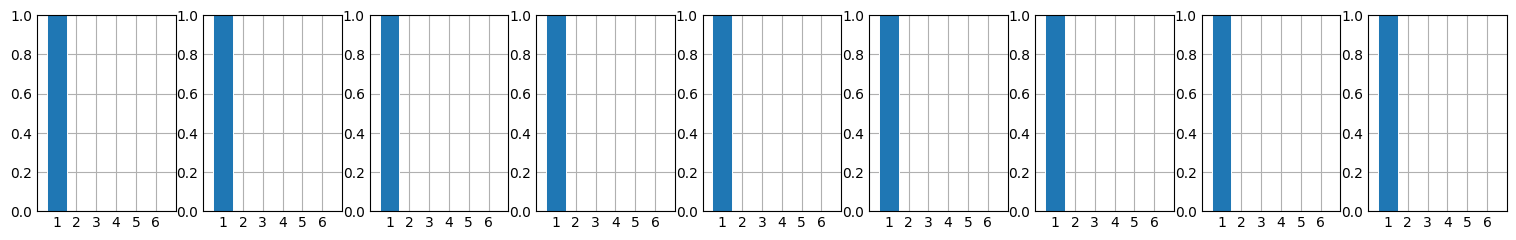

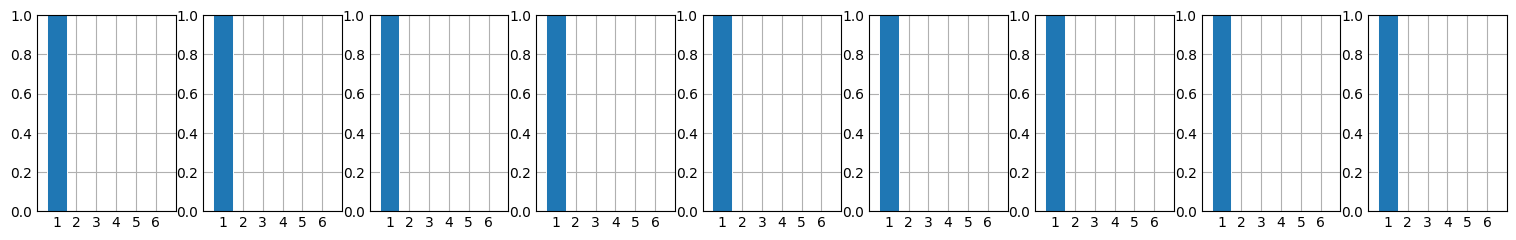

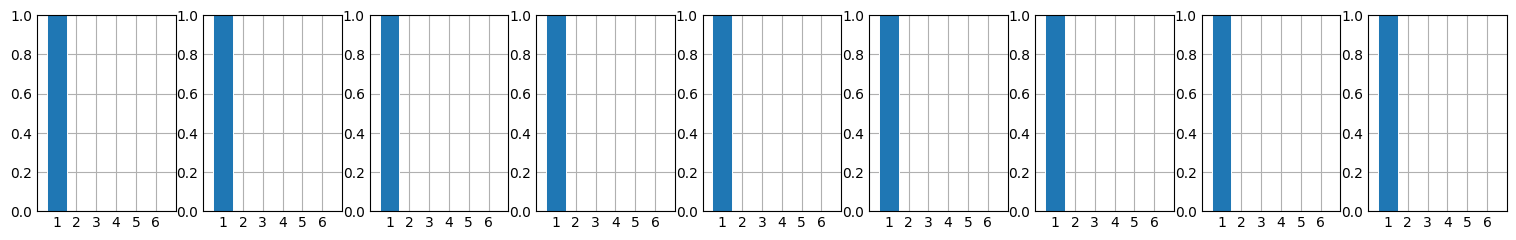

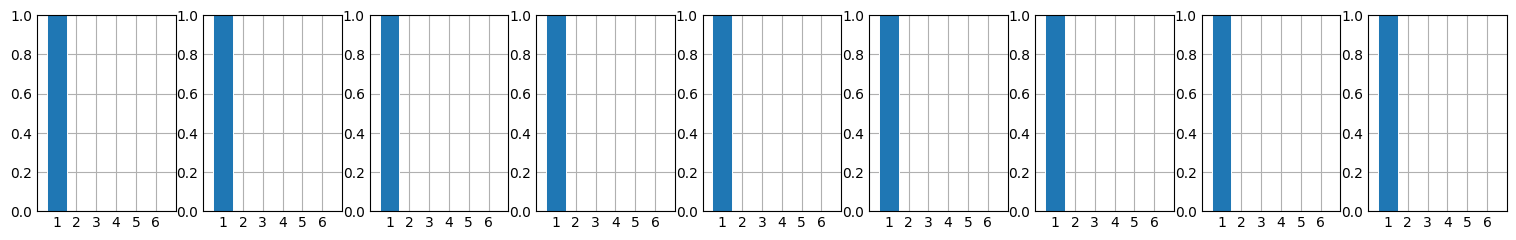

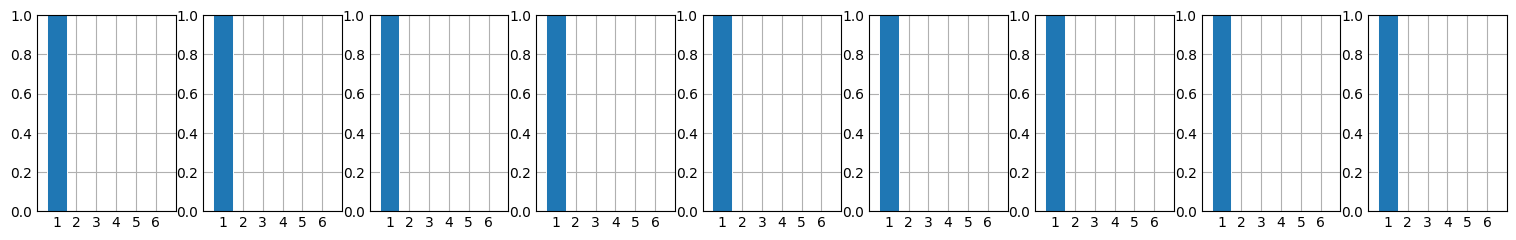

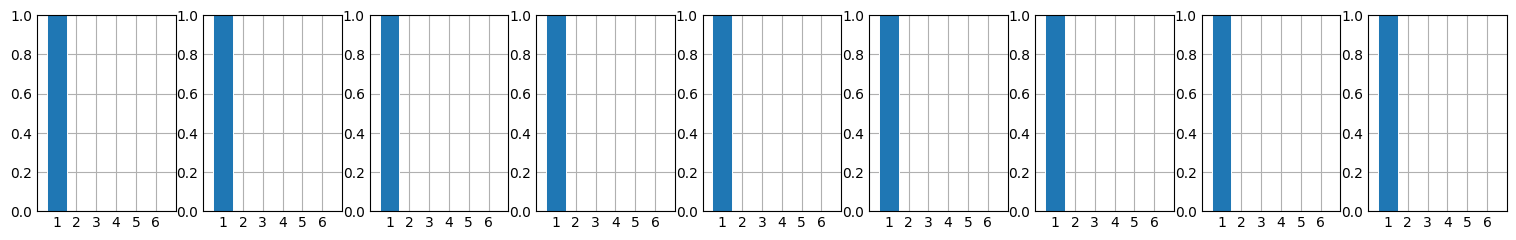

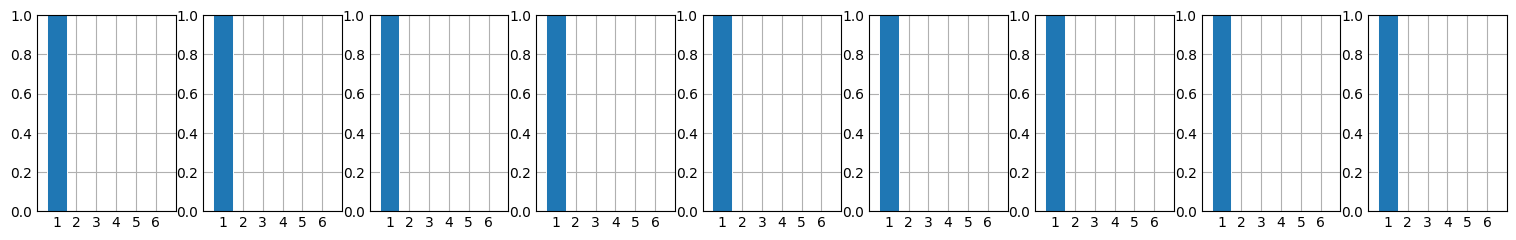

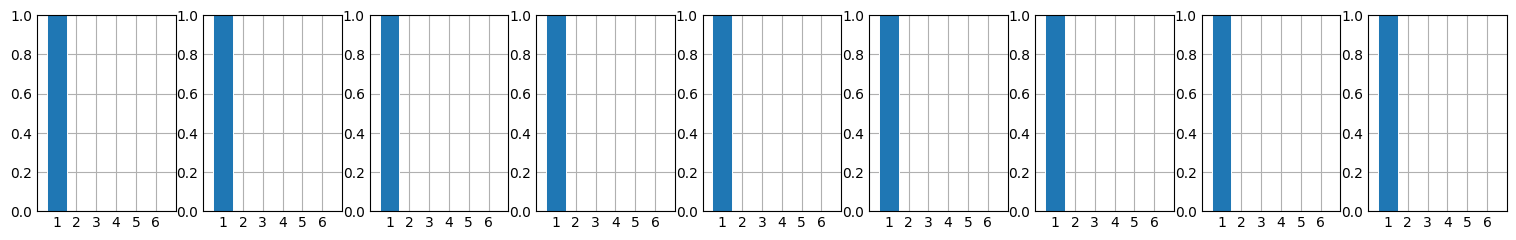

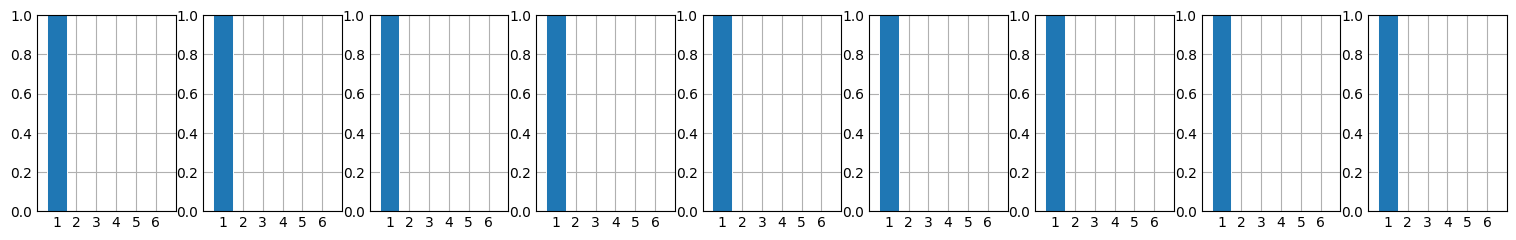

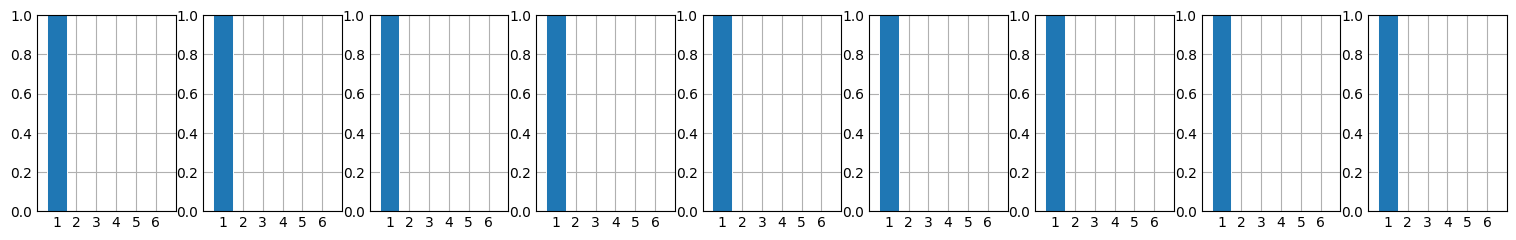

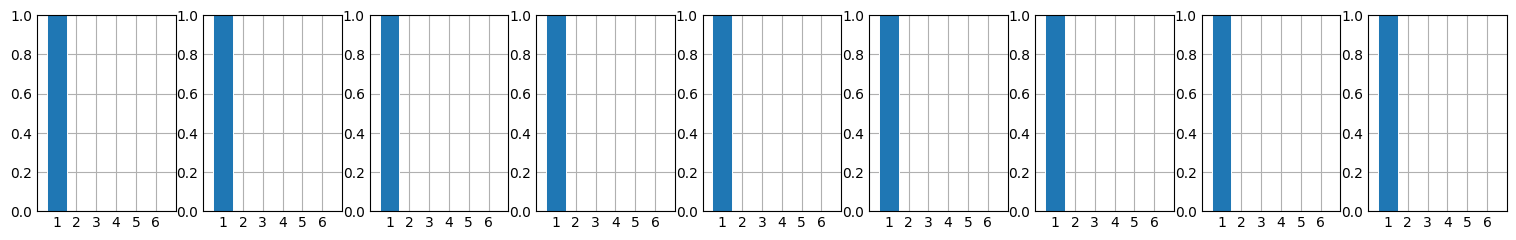

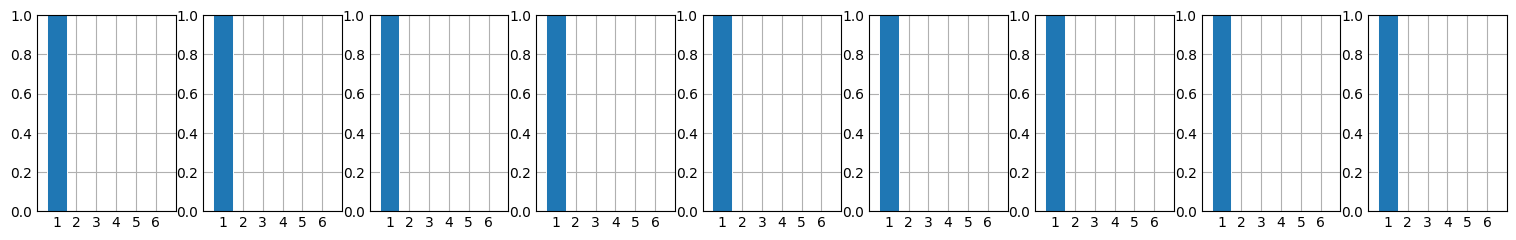

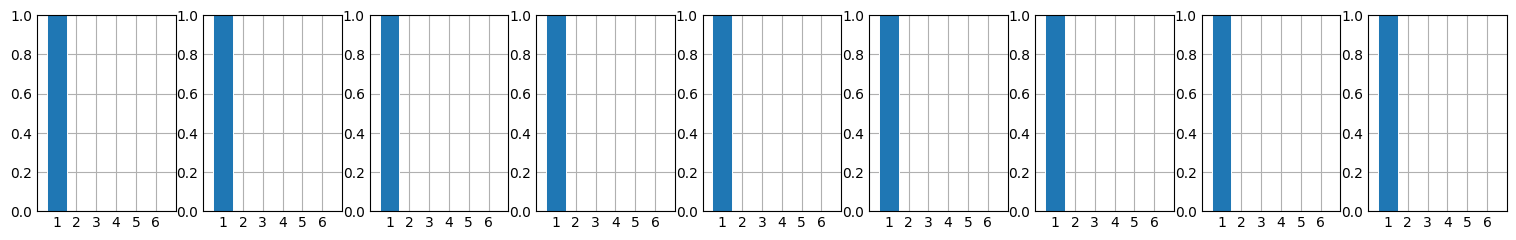

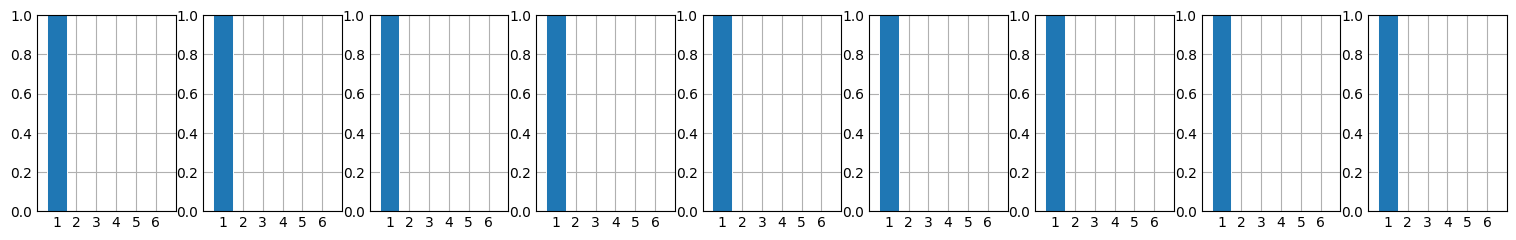

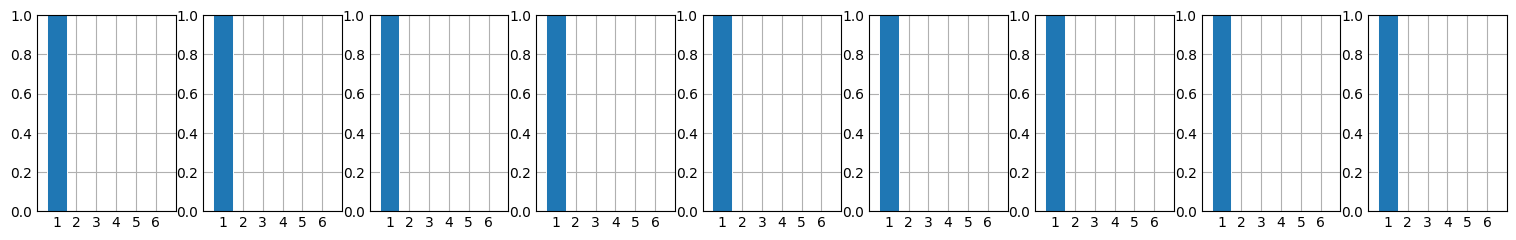

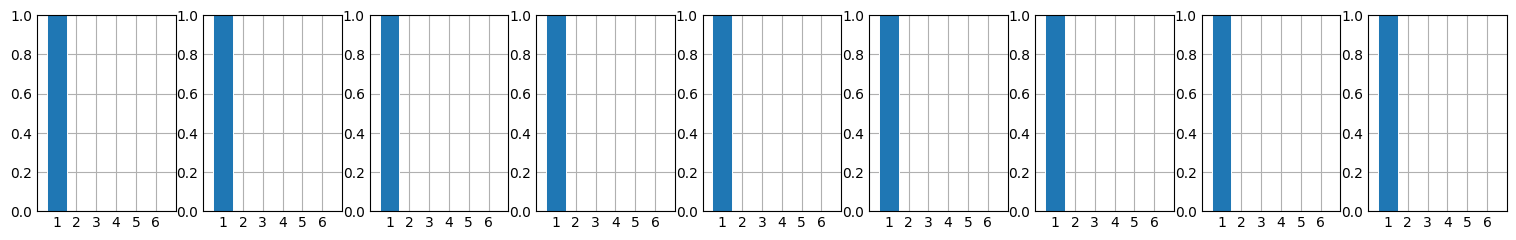

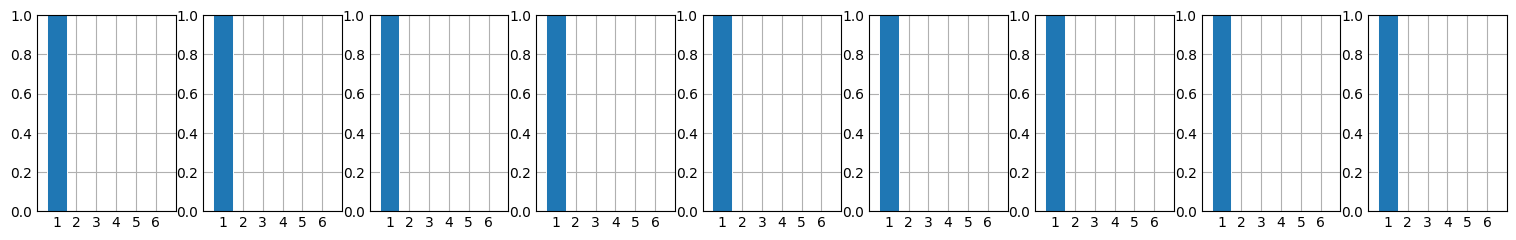

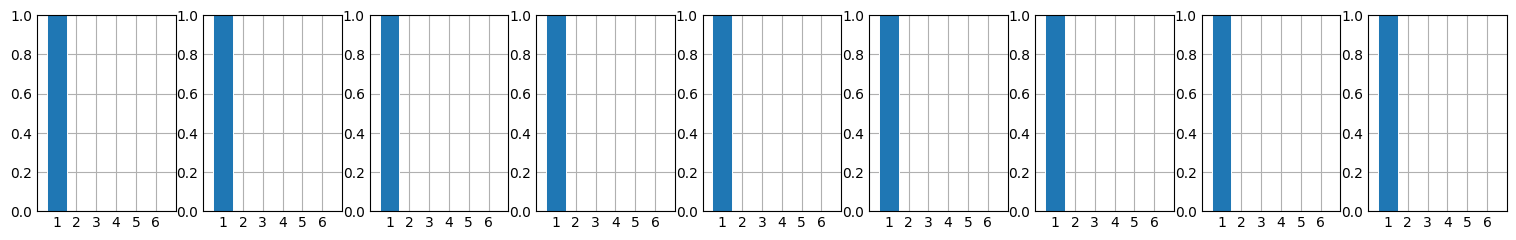

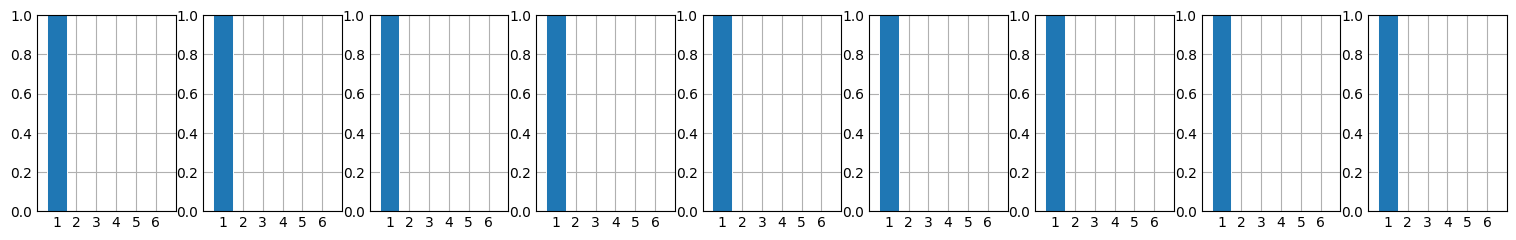

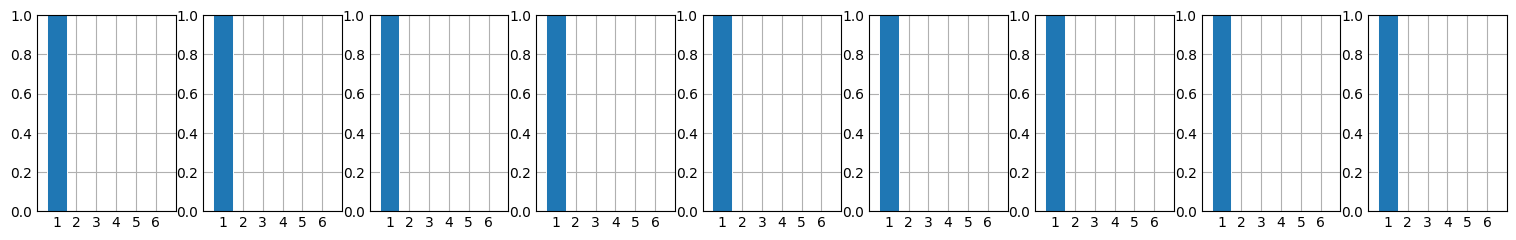

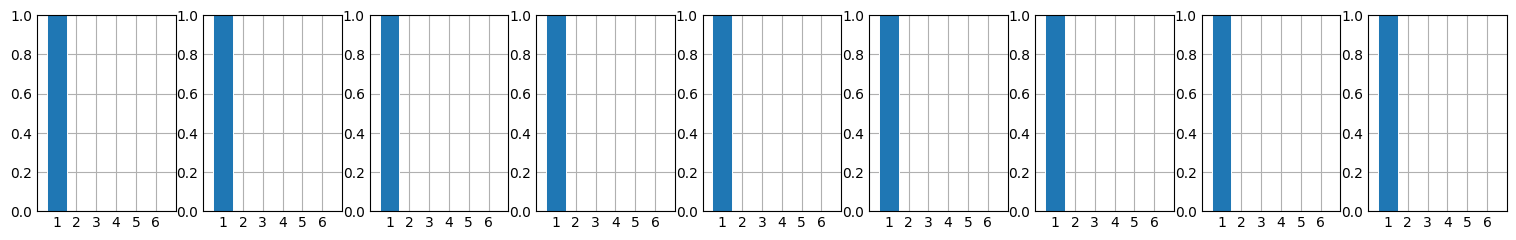

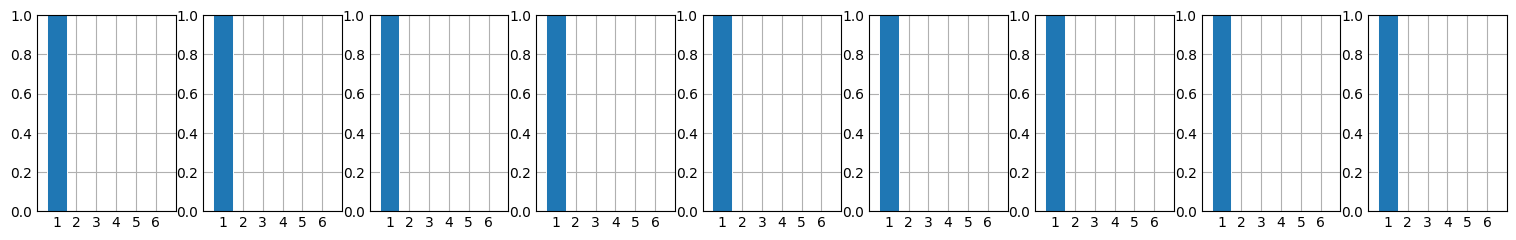

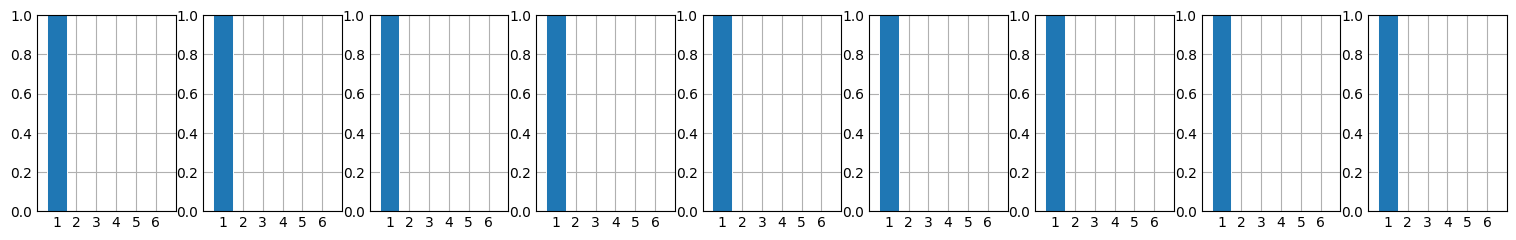

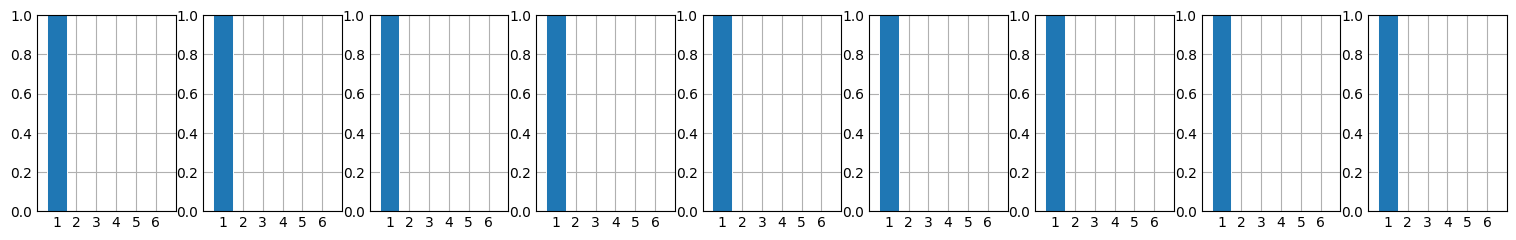

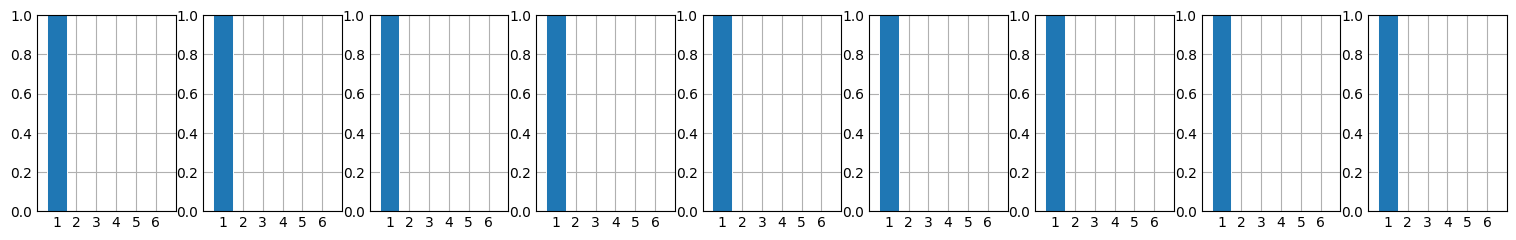

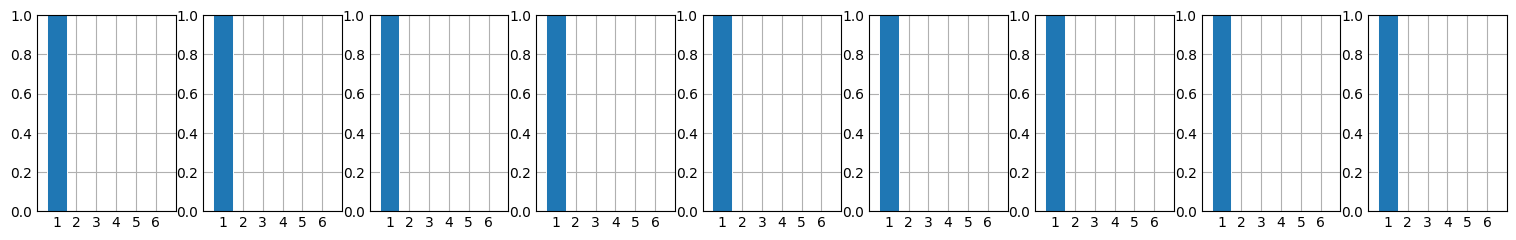

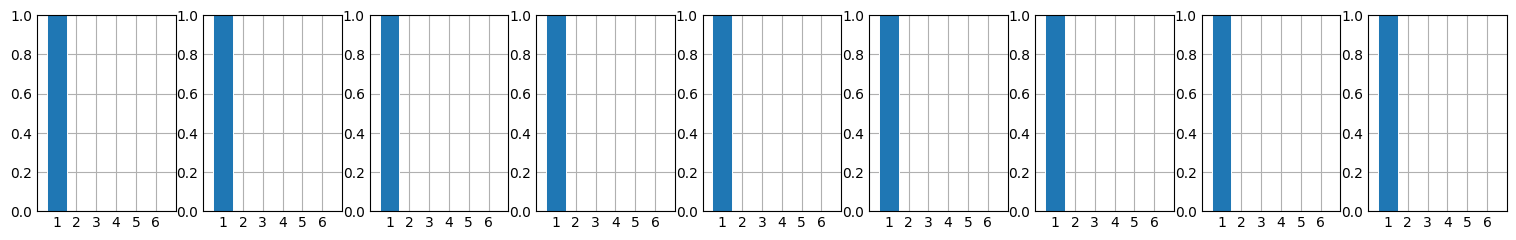

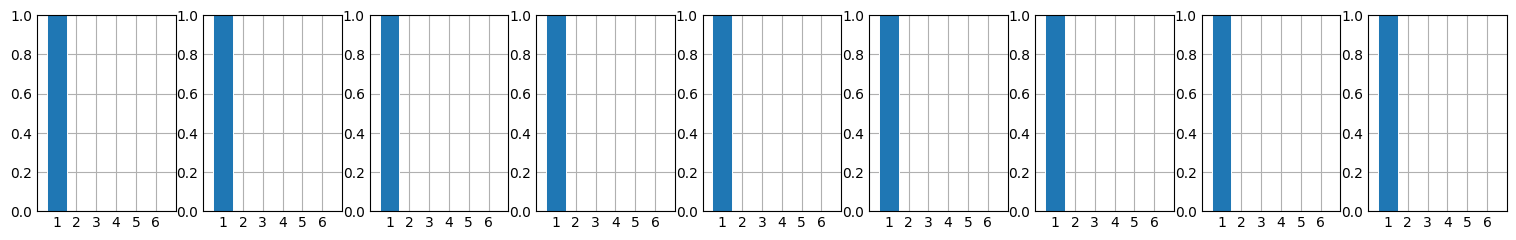

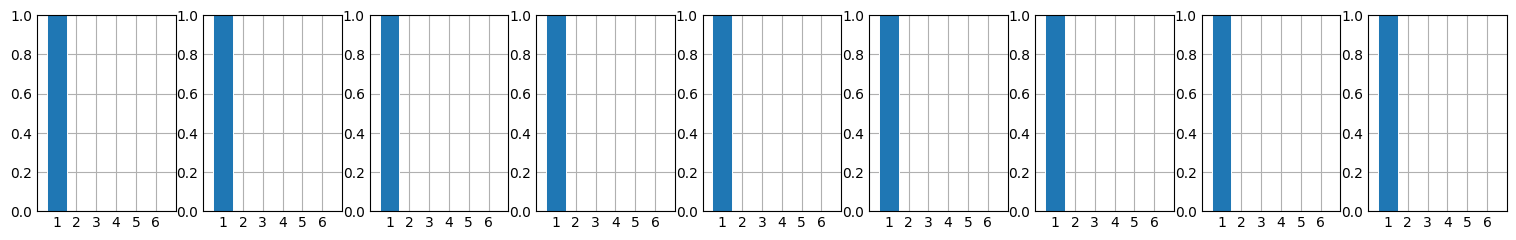

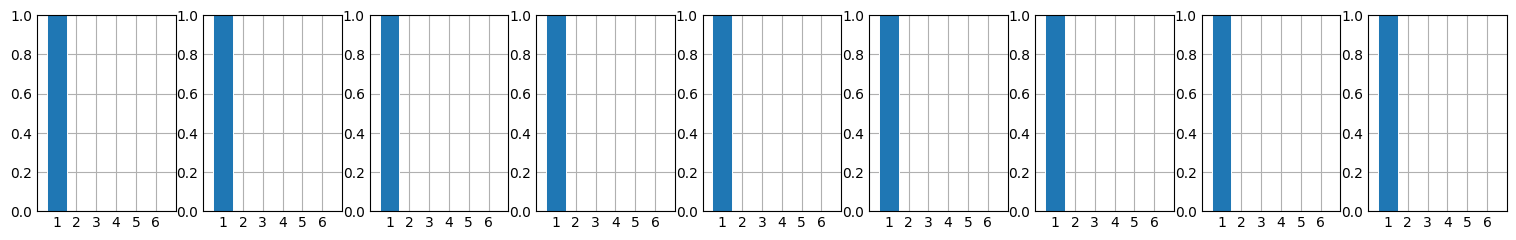

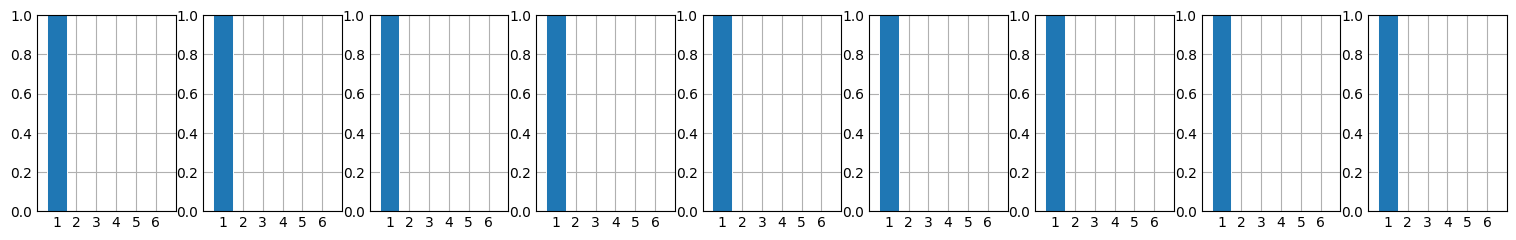

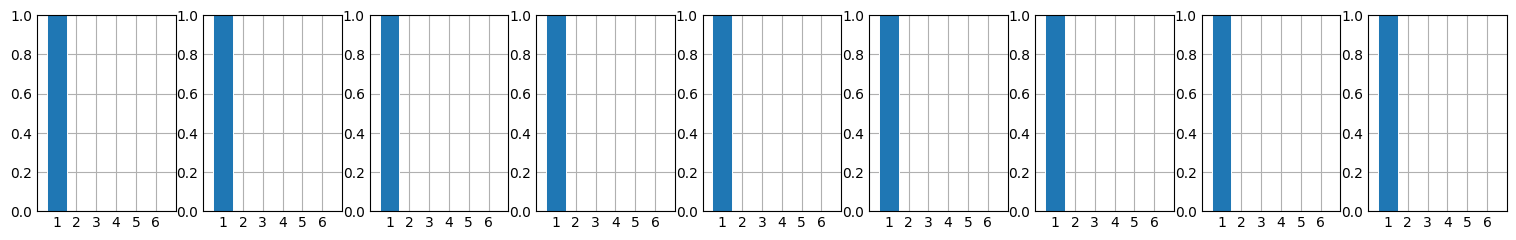

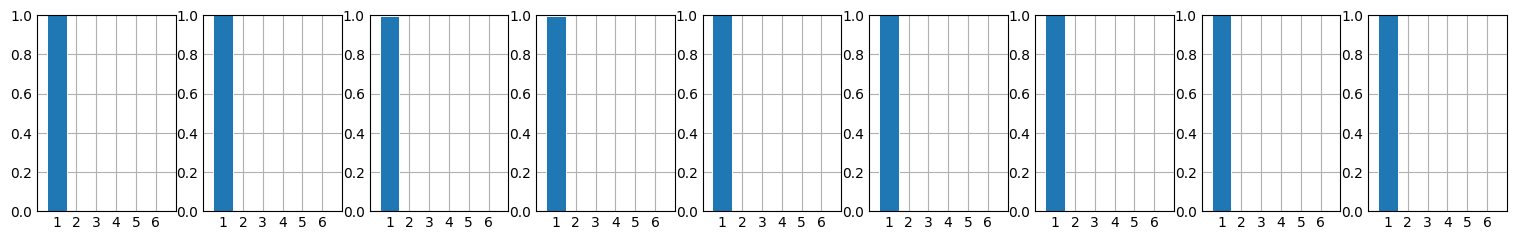

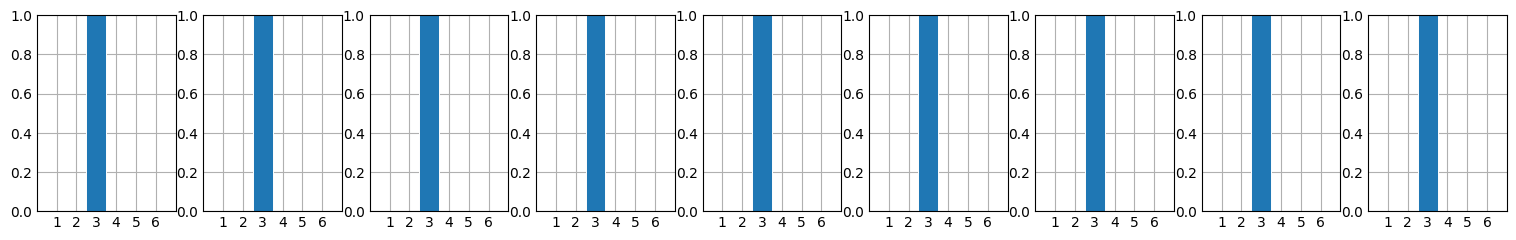

In [18]:
patient_ids = all_patients()
for patient_id in patient_ids:
    plot_patient(patient_id)

__END__